In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import vmo.analysis as van
import vmo.VMO.utility as utl
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
import scipy.stats as stats
import os, itertools, csv, librosa, vmo, glob, functools, pickle
from dtw import dtw

%matplotlib inline

In [3]:
file_path = '../JKUPDD-Aug2013/groundTruth/'
song_list = ['bachBWV889Fg', 'beethovenOp2No1Mvt3', 'chopinOp24No4', 'gibbonsSilverSwan1612', 'mozartK282Mvt2']
bpm_list = [84, 192, 138, 54, 120]
brange = [[1,110],[-1,555],[-1, 556],[1, 80],[-1,526]]
pattern_list = ['barlowAndMorgensternRevised', 'bruhn','schoenberg','sectionalRepetitions','tomCollins']

def get_occurence(f_path, pattern_list):
    f = itertools.chain.from_iterable([[_f+'/'+c+'/occurrences/csv/' for c in os.listdir(f_path+_f+'/') if not c.startswith('.')] 
                                        for _f in os.listdir(f_path) if (not _f.startswith('.') and _f in pattern_list)])
    f = list(f)
    occur = [[_c for _c in os.listdir(f_path+'/'+_f) if not _c.startswith('.')] for _f in f[:]]
    out = []
    for c,s in zip(occur, f):
        occ_list = []
        for _c in c:
            csv_file = open(f_path+s+_c,'r')
            cs = list(csv.reader(csv_file))
            region = [float(cs[0][0]),float(cs[-1][0])]
            occ_list.append(region)
        out.append(occ_list)
    return out

audio_list = [{'audio':[file_path+song+'/polyphonic/audio/'+a for a in os.listdir(file_path+song+'/polyphonic/audio/') if a.endswith('wav')][0],
               'info':(song, bpm, beat_range),
               'pattern':get_occurence(file_path+song+'/polyphonic/repeatedPatterns/', pattern_list)} 
                for song, bpm, beat_range in zip(song_list, bpm_list, brange)]

In [8]:
feature_path = 'motif_feature_0420'
f = open(feature_path, 'r')
feature_dict = pickle.load(f)
f.close()

Begin processing bachBWV889Fg
Begin processing beethovenOp2No1Mvt3
Begin processing chopinOp24No4
Begin processing gibbonsSilverSwan1612
Begin processing mozartK282Mvt2


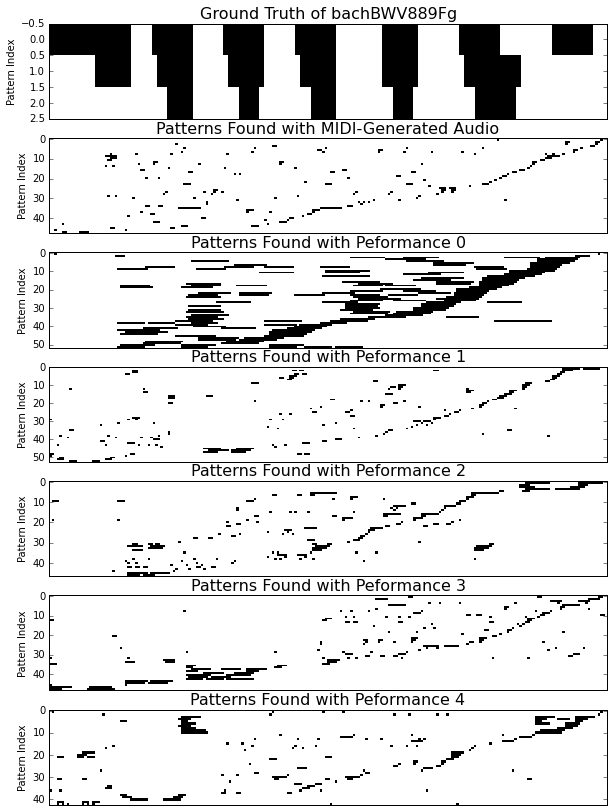

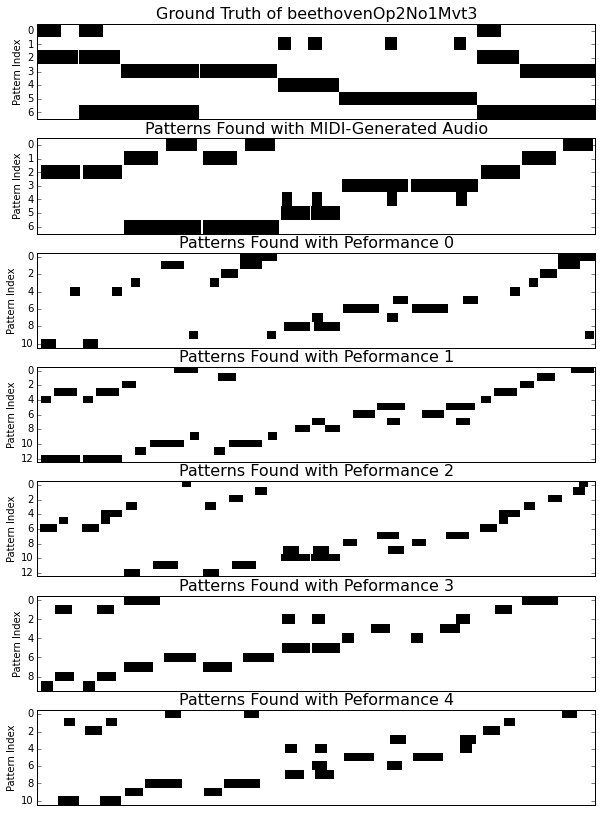

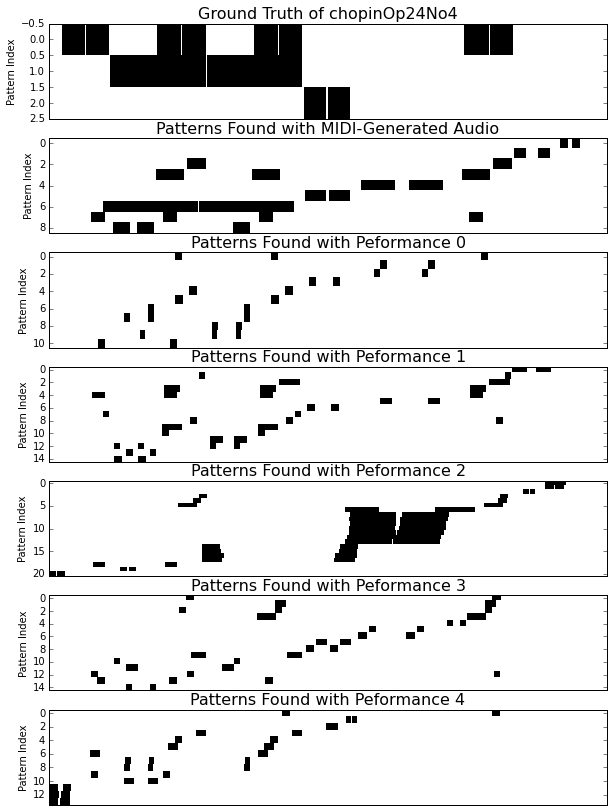

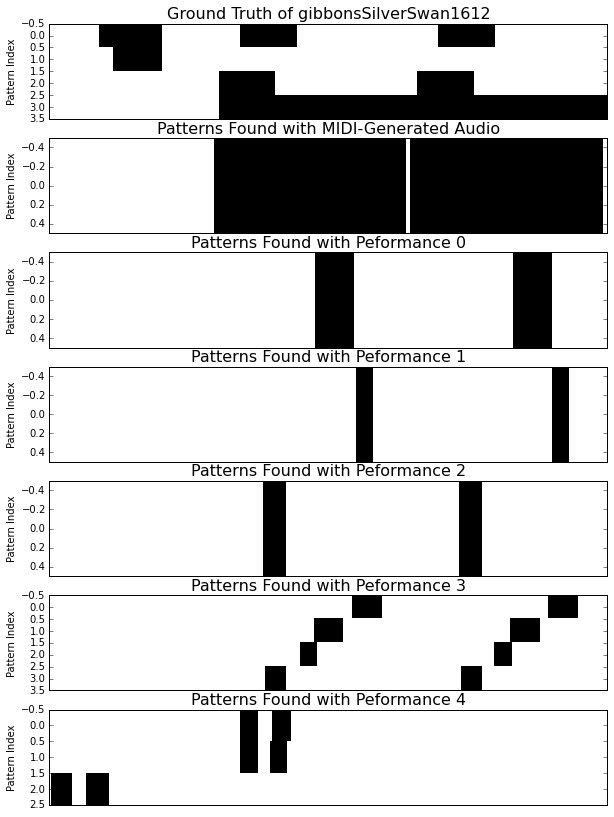

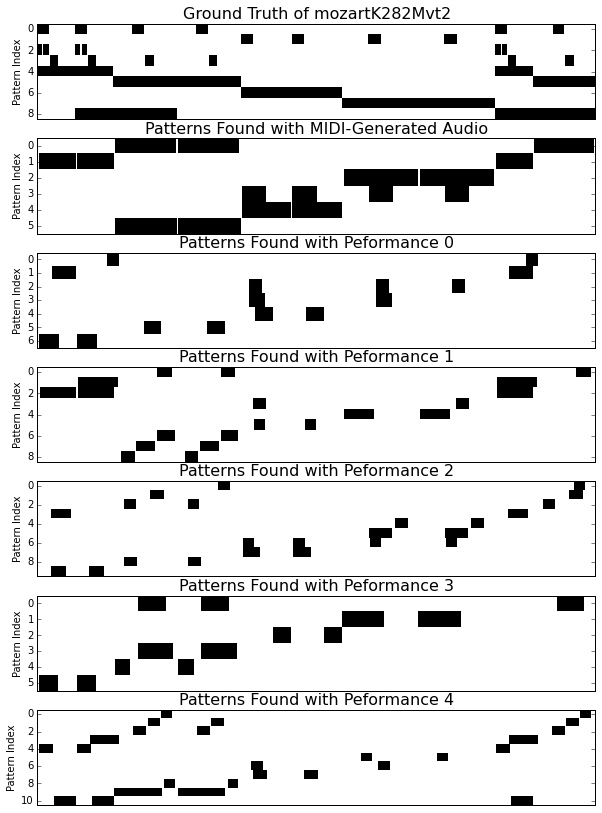

In [10]:
r = (0.0, 1.0, 0.01) 
shift = 5
step = 3
trnspose_inv = functools.partial(utl.trnspose_inv, shift = shift, step = step)
vmo_dict = {}
for ind in range(5):
    print 'Begin processing '+ song_list[ind]
    oracle_vec = []
    audio_test = audio_list[ind]
    piece_dict = feature_dict[song_list[ind]]
    c_list = piece_dict['chroma']
    b_list = piece_dict['beats']
    query = c_list[0]
    q_b = b_list[0]

    subbeats = []
    for bs, be in zip(q_b[:-1],q_b[1:]):
        subbeats.extend(np.linspace(bs, be, num = 2, endpoint = False).astype('int').tolist())
    subbeats.extend(np.linspace(q_b[-1], query.shape[1], num = 2, endpoint = False).astype('int').tolist())
    subbeats.append(query.shape[1])
    query_sync = librosa.feature.sync(query, subbeats, aggregate=np.median)

    query_sync = np.log(query_sync+np.finfo(float).eps)
    q_feature = pre.normalize(query_sync, axis = 0)
    
    ideal_q = vmo.find_threshold(q_feature.T, r = r, flag = 'a', dim = q_feature.shape[0], 
                                 dfunc = 'other', dfunc_handle = trnspose_inv, VERBOSE = False)
    oracle_q = vmo.build_oracle(q_feature.T, flag = 'a', dim = q_feature.shape[0],
                                threshold = ideal_q[0][1], 
                                feature = 'chroma', dfunc = 'other', dfunc_handle = trnspose_inv)
    
    oracle_vec.append(oracle_q)
    
    ground = np.zeros((len(audio_test['pattern']), audio_test['info'][2][1]-audio_test['info'][2][0]))
    for i,p in enumerate(audio_test['pattern']):
        for _p in p:
            start = _p[0] - audio_test['info'][2][0]
            end = _p[1] - audio_test['info'][2][0]
            ground[i][start:end+1] = 1
    min_len = int(np.mean(oracle_q.lrs)/2)
    
    pattern = van.find_repeated_patterns(oracle_q, lower = min_len)
    pattern_mat = np.zeros((len(pattern), oracle_q.n_states-1))
    for i,p in enumerate(pattern):
        length = p[1]
        for s in p[0]:
            pattern_mat[i][s-length:s-1] = 1
    
    target_vec = c_list[1:]
    t_beat_vec = b_list[1:]
    
    plt.figure(figsize = (10,14))
    plt.subplot(7,1,1)
    plt.imshow(ground, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
    plt.title('Ground Truth of '+song_list[ind], fontsize = 16)
    plt.ylabel('Pattern Index')
    plt.xticks([])
    plt.subplot(7,1,2)
    plt.imshow(pattern_mat, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
    plt.title('Patterns Found with MIDI-Generated Audio', fontsize=16)
    plt.ylabel('Pattern Index')
    plt.xticks([])

    for target_ind in range(5):
        target = target_vec[target_ind]
        t_beat = t_beat_vec[target_ind]
        subbeats = []
        for bs, be in zip(t_beat[:-1],t_beat[1:]):
            subbeats.extend(np.linspace(bs, be, num = 2, endpoint = False).astype('int').tolist())
        subbeats.extend(np.linspace(t_beat[-1], target.shape[1], num = 2, endpoint = False).astype('int').tolist())
        subbeats.append(target.shape[1])
        target_sync = librosa.feature.sync(target, subbeats, aggregate=np.median)

        target_sync = np.log(target_sync+np.finfo(float).eps)
        t_feature = pre.normalize(target_sync, axis = 0)
        
        dist, cost, path = dtw(q_feature.T, t_feature.T)

        reconstruct = np.zeros((cost.shape[0], 12))
        for q,t in zip(path[0][1:],path[1][1:]):
            reconstruct[q,:] = reconstruct[q,:] + t_feature[:,t].T 
        reconstruct = pre.normalize(reconstruct, axis = 1)

        ideal_t = vmo.find_threshold(reconstruct, r = r, flag = 'a', dim = reconstruct.shape[1],
                                     dfunc = 'other', dfunc_handle = trnspose_inv)
        oracle_t = vmo.build_oracle(reconstruct, flag = 'a', dim = reconstruct.shape[1],
                                    threshold = ideal_t[0][1], 
                                    feature = 'chroma', dfunc = 'other', dfunc_handle = trnspose_inv)
        oracle_vec.append(oracle_t)
        pattern = van.find_repeated_patterns(oracle_t, lower = min_len)
        pattern_mat = np.zeros((len(pattern), oracle_t.n_states-1))
        for i,p in enumerate(pattern):
            length = p[1]
            for s in p[0]:
                pattern_mat[i][s-length:s-1] = 1
        
        plt.subplot(7,1,target_ind+3)
        plt.imshow(pattern_mat, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
        plt.title('Patterns Found with Peformance '+str(target_ind), fontsize=16)
        plt.ylabel('Pattern Index')
        plt.xticks([])
        
    vmo_dict[song_list[ind]] = oracle_vec
    plt.savefig('Pattern Comparison of '+song_list[ind]+'.pdf')

In [11]:
f = open('motif_vmo_0421','w')
pickle.dump(vmo_dict, f)
f.close()